In [1]:
import json
import math
import random
from rastrigin import rastrigin
from sphere import sphere_function
import numpy as np
import matplotlib.pyplot as plt
import copy
import pandas as pd

fitness_function = sphere_function

numberOfIterations = 1000
numberOfAgents = 50
dimensions = 5
minRast = -5.12
maxRast = 5.12

settings = {
    "startEnergy": 100,
    "mutation_probability": 0.5,
    "mutation_element_probability": 0.2,
    "crossover_probability": 0.5,
    "distribution_index": 0.2,
    "fightLossEnergy": 0.05,
    "reproduceLossEnergy": 0.25,
    "fightReqEnergy": 0,
    "reproduceReqEnergy": 150
}

pandas_data_agents = {
    "nr": [],
    "x": [],
    "start_energy": [],
    "fitness": []
}

pandas_data = {
    "iter": [],
    "number_of_agents": [],
    "born_agents": [],
    "dead_agents": [],
    "best_agent_fitness": [],
    "average_fitness": [],
    "best_agent_energy": [],
    "average_energy": [],
    "min_std_dev": [],
    "max_std_dev": [],
    "lowest_energy": [],
    "sum_energy": []
}


pandas_data_agents_energy = dict()
pandas_data_dead_agents_energy = []


def add_agent_to_pd_energy(agent):
    if len(pandas_data_agents_energy) == 0:
        pandas_data_agents_energy.append([agent.energy])
    else:
        next_idx = len(pandas_data_agents_energy)
        pandas_data_agents_energy.append([ 0 for agent_idx in range(len(pandas_data_agents_energy[next_idx-1])-1)])
        pandas_data_agents_energy[next_idx].append(agent.energy)
        

In [20]:
class Agent:
    def __init__(self, x, energy=settings["startEnergy"], iterr = 0):
        self.x = x
        self.energy = energy
        self.fitness = fitness_function(x)
        self.energy_history = [(iterr, energy)]

    @staticmethod
    def crossover(parent1, parent2):
        parents = [parent1, parent2]
        offspring = copy.deepcopy(parents)
        permutation_length = len(offspring[0].x)

        cross_points = sorted([random.randint(0, permutation_length) for _ in range(2)])

        def _repeated(element, collection):
            c = 0
            for e in collection:
                if e == element:
                    c += 1
            return c > 1

        def _swap(data_a, data_b, cross_points):
            c1, c2 = cross_points
            new_a = data_a[:c1] + data_b[c1:c2] + data_a[c2:]
            new_b = data_b[:c1] + data_a[c1:c2] + data_b[c2:]
            return new_a, new_b

        def _map(swapped, cross_points):
            n = len(swapped[0])
            c1, c2 = cross_points
            s1, s2 = swapped
            map_ = s1[c1:c2], s2[c1:c2]
            for i_chromosome in range(n):
                if not c1 < i_chromosome < c2:
                    for i_son in range(2):
                        while _repeated(swapped[i_son][i_chromosome], swapped[i_son]):
                            try:
                                map_index = map_[i_son].index(swapped[i_son][i_chromosome])
                                swapped[i_son][i_chromosome] = map_[1 - i_son][map_index]
                            except ValueError as ve:
                                print('ValueError encountered, Action skipped')
                                break
            return s1, s2

        swapped = _swap(parents[0].x, parents[1].x, cross_points)
        mapped = _map(swapped, cross_points)

        offspring[0].x, offspring[1].x = mapped

        return offspring[0].x, offspring[1].x
    
    def add_energy_to_history(self, iterr):
        self.energy_history.append((iterr, self.energy))
    
    @staticmethod
    def mutate(x):
        for i in range(len(x)):
            rand = random.random()

            if rand <= 1 / len(x):
                y = x[i]
                yl, yu = minRast, maxRast

                if yl == yu:
                    y = yl
                else:
                    delta1 = (y - yl) / (yu - yl)
                    delta2 = (yu - y) / (yu - yl)
                    rnd = random.random()
                    mut_pow = 1.0 / (settings["distribution_index"] + 1.0)
                    if rnd <= 0.5:
                        xy = 1.0 - delta1
                        val = 2.0 * rnd + (1.0 - 2.0 * rnd) * (
                            pow(xy, settings["distribution_index"] + 1.0))
                        deltaq = pow(val, mut_pow) - 1.0
                    else:
                        xy = 1.0 - delta2
                        val = 2.0 * (1.0 - rnd) + 2.0 * (rnd - 0.5) * (
                            pow(xy, settings["distribution_index"] + 1.0))
                        deltaq = 1.0 - pow(val, mut_pow)

                    y += deltaq * (yu - yl)
                    if y < minRast:
                        y = minRast
                    if y > maxRast:
                        y = maxRast
                x[i] = y
        return x

    @staticmethod
    def reproduce(parent1, parent2, loss_energy, f_avg, iterr):
        parent1_loss = math.ceil(parent1.energy * loss_energy)
        parent1.energy -= parent1_loss

        parent2_loss = math.ceil(parent2.energy * loss_energy)
        parent2.energy -= parent2_loss

        # Possible crossover
        if random.random() < settings["crossover_probability"]:
            newborns = Agent.crossover(parent1, parent2)
            newborn_x1, newborn_x2 = newborns[0], newborns[1]
        else:
            newborns = Agent.crossover(parent2, parent1)
            newborn_x1, newborn_x2 = newborns[0], newborns[1]

        mutation_probability_x1 = mutation_probability_x2 = settings["mutation_probability"]

        if fitness_function(newborn_x1) < f_avg:
            mutation_probability_x1 /= 2
        else:
            mutation_probability_x1 *= 2

        if fitness_function(newborn_x2) < f_avg:
            mutation_probability_x2 /= 2
        else:
            mutation_probability_x2 *= 2

        random_number = random.random()
        if random_number < mutation_probability_x1:
            newborn_x1 = Agent.mutate(newborn_x1)
        if random_number < mutation_probability_x2:
            newborn_x2 = Agent.mutate(newborn_x2)

        newborn1 = Agent(newborn_x1, parent1_loss + parent2_loss, iterr)
        newborn2 = Agent(newborn_x2, parent1_loss + parent2_loss, iterr)
        
        if newborn1.fitness < newborn2.fitness:
            pandas_data_agents["nr"].append(len(pandas_data_agents["nr"]))
            pandas_data_agents["x"].append(newborn1.x)
            pandas_data_agents["start_energy"].append(newborn1.energy)
            pandas_data_agents["fitness"].append(newborn1.fitness)
#             add_agent_to_pd_energy(newborn1)
            return newborn1
        else:
            pandas_data_agents["nr"].append(len(pandas_data_agents["nr"]))
            pandas_data_agents["x"].append(newborn2.x)
            pandas_data_agents["start_energy"].append(newborn2.energy)
            pandas_data_agents["fitness"].append(newborn2.fitness)
#             add_agent_to_pd_energy(newborn2)
            return newborn2

    @staticmethod
    def fight(agent_1, agent_2, loss_energy):
        if agent_1.fitness < agent_2.fitness:
            energy = agent_2.energy * loss_energy
            agent_1.energy += energy
            agent_2.energy -= energy
        else:
            energy = agent_1.energy * loss_energy
            agent_1.energy -= energy
            agent_2.energy += energy

        agent_1.energy = np.true_divide(np.floor(agent_1.energy * 10**8), 10**8)
        agent_2.energy = np.true_divide(np.floor(agent_2.energy * 10**8), 10**8)

    

    # @staticmethod
    # def fight(agent_1, agent_2, loss_energy):
    #     if agent_1.fitness < agent_2.fitness:
    #         energy = agent_2.energy
    #         agent_1.energy += energy
    #         agent_2.energy -= energy
    #     else:
    #         energy = agent_1.energy
    #         agent_1.energy -= energy
    #         agent_2.energy += energy

    def is_dead(self):
        return self.energy <= 0
    

In [23]:
class EMAS:
    def __init__(self, agents):
        self.agents = agents
        self.iteration = 0

    def run_iteration(self):
        random.shuffle(self.agents)

        children = self.reproduce()
        self.fight()
        for agent in self.agents:
            agent.add_energy_to_history(self.iteration)

        self.agents.extend(children)
#         for idx, agent in enumerate(self.agents):
#             pandas_data_agents_energy[idx].append(agent.energy)
        dead = self.clear()
        self.iteration += 1
        
        return len(children), len(dead)

    def reproduce(self):
        req_energy = settings["reproduceReqEnergy"]
        loss_energy = settings["reproduceLossEnergy"]

        parents = []
        children = []
        for idx, parent1 in enumerate(self.agents):
            if parent1.energy > req_energy and parent1 not in parents:
                available_parents = [agent for agent in self.agents if
                                     agent != parent1 and agent.energy > req_energy and agent not in parents]
                if available_parents:
                    parent2 = random.choice(available_parents)
                    children.append(Agent.reproduce(parent1, parent2, loss_energy,
                                                    np.average([agent.fitness for agent in self.agents]), self.iteration))
                    parents.extend([parent1, parent2])

        return children

    def fight(self):
        req_energy = settings["fightReqEnergy"]
        loss_energy = settings["fightLossEnergy"]

        fighters = []
        for idx, agent1 in enumerate(self.agents):
            if agent1.energy > req_energy and agent1 not in fighters:
                available_fighters = [agent for agent in self.agents if
                                      agent != agent1 and agent.energy > req_energy and agent not in fighters]
                if available_fighters:
                    agent2 = random.choice(available_fighters)
                    Agent.fight(agent1, agent2, loss_energy)
                    fighters.extend([agent1, agent2])

    def clear(self):
        dead = []
        for idx, agent in enumerate(self.agents):
            if agent.is_dead():
                dead.append(agent)
                
                next_item = len(pandas_data_dead_agents_energy)
                pandas_data_dead_agents_energy.append([])
                first_iter, first_energy = agent.energy_history[0]
                for i in range(first_iter):
                    pandas_data_dead_agents_energy[next_item].append(0)
                for a in agent.energy_history:
                    pandas_data_dead_agents_energy[next_item].append(a[1])
        
        self.agents = [agent for agent in self.agents if not agent.is_dead()]
        return dead

In [ ]:
def generate_agents():
    gen_agents = [Agent([random.uniform(minRast, maxRast) for _ in range(dimensions)]) for _ in range(numberOfAgents)]
    
    for agent in gen_agents:
#         add_agent_to_pd_energy(agent)
        pandas_data_agents["nr"].append(len(pandas_data_agents["nr"]))
        pandas_data_agents["x"].append(agent.x)
        pandas_data_agents["start_energy"].append(agent.energy)
        pandas_data_agents["fitness"].append(agent.fitness)
        
    return gen_agents


def save_to_file(output):
    settings['function'] = fitness_function.__name__
    settings['output'] = output
    try:
        with open("results.txt", 'a+') as file:
            json.dump(settings, file, indent=4)
            file.write('\n')
    except Exception as e:
        print("Error while saving results to file:", e)


In [41]:
def main():
    agents = generate_agents()

    emas = EMAS(agents)

    total_number_of_born, total_number_of_dead = 0, 0
    data = []
    for it in range(numberOfIterations):
        # Number of agents, born agents and dead agents
        born_num, dead_num = emas.run_iteration()
        total_number_of_born += born_num
        total_number_of_dead += dead_num
        agents_num = len(emas.agents)
        energy_sum = np.sum([agent.energy for agent in emas.agents])

        if it%10 == 0:
            print(it, agents_num)


        # Min and Max standard deviations along each dimension for agents
        vectors = np.array([agent.x for agent in emas.agents])
        std = np.std(vectors, axis=0)
        min_std = min(std)
        max_std = max(std)

        # Best agent based on its fitness
        best_agent = min(emas.agents, key=lambda agent: agent.fitness)
        lowest_energy = min(emas.agents, key=lambda agent: agent.energy).energy
        # print(it, agents_num)
        
        fitness_avg = np.average([agent.fitness for agent in emas.agents])
        energy_avg = np.average([agent.energy for agent in emas.agents])
        
        # Add data
        data.append((
            agents_num,
            born_num,
            dead_num,
            best_agent.fitness,
            fitness_avg,
            best_agent.energy,
            energy_avg,
            min_std,
            max_std,
            energy_sum
        ))
        
        # Add data to dataFrame
        pandas_data["iter"].append(it)
        pandas_data["number_of_agents"].append(agents_num)
        pandas_data["born_agents"].append(born_num)
        pandas_data["dead_agents"].append(dead_num)
        pandas_data["best_agent_fitness"].append(best_agent.fitness)
        pandas_data["average_fitness"].append(fitness_avg)
        pandas_data["best_agent_energy"].append(best_agent.energy)
        pandas_data["average_energy"].append(energy_avg)
        pandas_data["min_std_dev"].append(min_std)
        pandas_data["max_std_dev"].append(max_std)
        pandas_data["lowest_energy"].append(lowest_energy)
        pandas_data["sum_energy"].append(energy_sum)

    print("Number of agents left:", len(emas.agents))
    print()
    print("Total number of born agents:", total_number_of_born)
    print("Total number of dead agents:", total_number_of_dead)
    print()

    best_agent = min(emas.agents, key=lambda agent: agent.fitness)

    for i in range(len(best_agent.x)):
        best_agent.x[i] = round(best_agent.x[i], 2)

    output = f"Minimum in {best_agent.x} equals = {best_agent.fitness:.2f} for agent with energy equals = {best_agent.energy:.2f}"
    print(output)
    
    # fill pandas data energy
    for idx, agent in enumerate(emas.agents):
        next_item = len(pandas_data_dead_agents_energy)
        pandas_data_dead_agents_energy.append([])
        first_iter, first_energy = agent.energy_history[0]
        for i in range(first_iter):
            pandas_data_dead_agents_energy[next_item].append(0)
        for a in agent.energy_history:
            pandas_data_dead_agents_energy[next_item].append(a[1])
    
    for idx, agent in enumerate(pandas_data_dead_agents_energy):
        if len(agent) != emas.iteration:
            diff = emas.iteration - len(agent)
            for iterrr in range(diff):
                agent.append(0)
        if len(agent) > emas.iteration:
            diff = len(agent) - emas.iteration
            agent = agent[:-diff]
        pandas_data_agents_energy[str(idx)] = agent
    pandas_data_agents_energy['iter'] = [ i for i in range(emas.iteration)]

main()

0 50
10 50
20 57
30 61
40 65
50 67
60 72
70 76
80 77
90 81
100 83
110 86
120 88
130 92
140 94
150 96
160 97
170 100
180 101
190 105
200 108
210 110
220 112
230 115
240 116
250 118
260 120
270 122
280 123
290 125
300 129
310 129
320 130
330 131
340 133
350 135
360 136
370 139
380 141
390 143
400 145
410 144
420 145
430 143
440 143
450 143
460 143
470 144
480 144
490 145
500 144
510 144
520 144
530 143
540 143
550 143
560 144
570 143
580 143
590 141
600 141
610 140
620 142
630 141
640 141
650 139
660 136
670 136
680 134
690 131
700 131
710 131
720 130
730 130
740 130
750 131
760 130
770 130
780 130
790 130
800 130
810 130
820 130
830 131
840 130
850 130
860 130
870 130
880 129
890 129
900 127
910 123
920 122
930 122
940 122
950 121
960 120
970 116
980 112
990 109
Number of agents left: 107

Total number of born agents: 137
Total number of dead agents: 80

Minimum in [0.16, -0.16, -0.19, 0.02, 0.15] equals = 0.11 for agent with energy equals = 93.76


In [42]:
    df_agents = pd.DataFrame(pandas_data) 
    display(df_agents)

,iter,number_of_agents,born_agents,dead_agents,best_agent_fitness,average_fitness,best_agent_energy,average_energy,min_std_dev,max_std_dev,lowest_energy,sum_energy
0,0,50,0,0,8.981828,41.124819,105.000000,100.000000,2.386589,3.010765,9.500000e+01,5000.000000
1,1,50,0,0,8.981828,41.124819,110.250000,100.000000,2.386589,3.010765,9.025000e+01,5000.000000
2,2,50,0,0,8.981828,41.124819,115.237500,100.000000,2.386589,3.010765,8.573750e+01,5000.000000
3,3,50,0,0,8.981828,41.124819,119.524375,100.000000,2.386589,3.010765,8.145063e+01,5000.000000
4,4,50,0,0,8.981828,41.124819,124.476844,100.000000,2.386589,3.010765,7.737809e+01,5000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2995,995,109,0,1,0.109556,1.256422,75.217323,45.871554,0.154318,0.796458,2.000000e-08,4999.999418
2996,996,109,0,0,0.109556,1.256422,94.997853,45.871554,0.154318,0.796458,1.000000e-08,4999.999417
2997,997,108,0,1,0.109556,1.211577,69.635426,46.296291,0.151453,0.772451,1.000000e-08,4999.999417
2998,998,107,0,1,0.109556,1.170167,92.137610,46.728967,0.148409,0.746651,2.000000e-08,4999.999416


<Axes: xlabel='iter'>

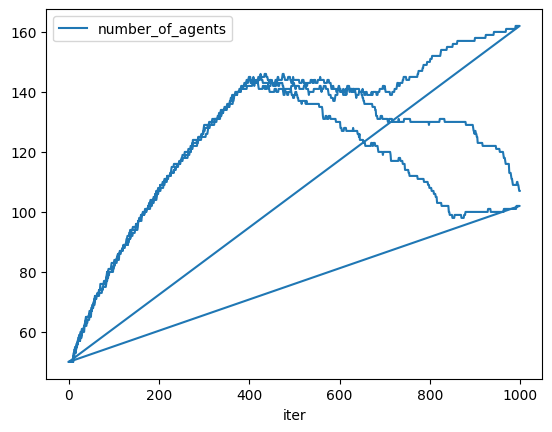

In [43]:
df_agents.plot(x="iter", y="number_of_agents")

<Axes: xlabel='iter'>

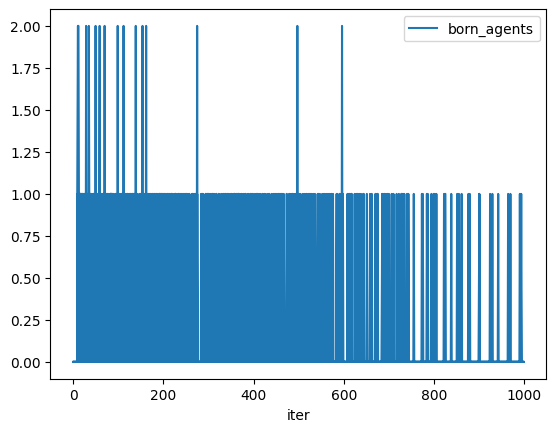

In [44]:
df_agents.plot(x="iter", y="born_agents")

<Axes: xlabel='iter'>

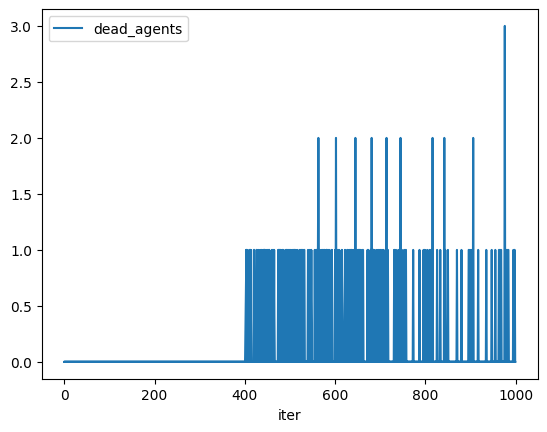

In [45]:
df_agents.plot(x="iter", y="dead_agents")

<Axes: xlabel='iter'>

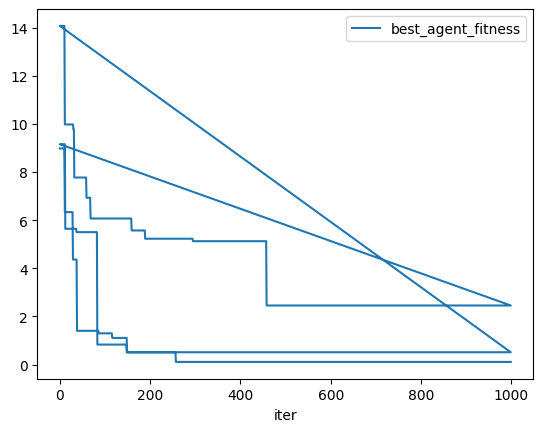

In [46]:
df_agents.plot(x="iter", y="best_agent_fitness")

<Axes: xlabel='iter'>

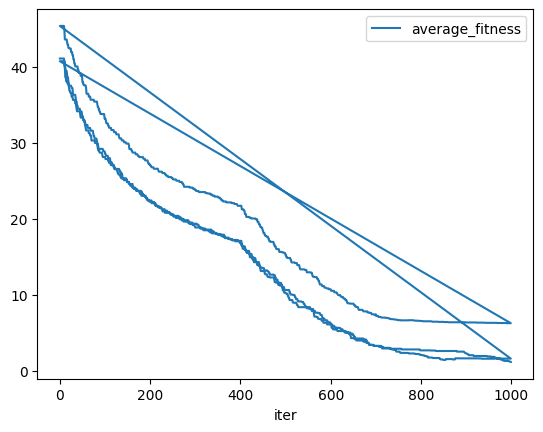

In [47]:
df_agents.plot(x="iter", y="average_fitness")

<Axes: xlabel='iter'>

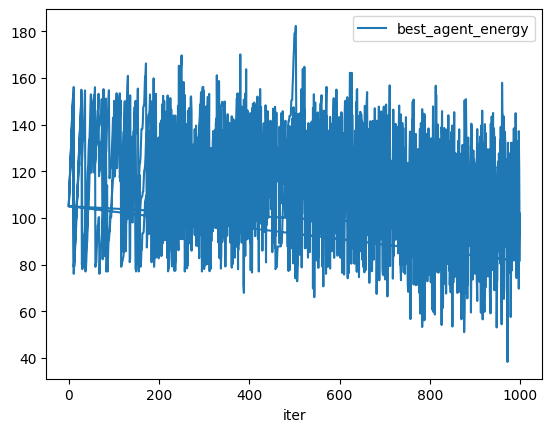

In [48]:
df_agents.plot(x="iter", y="best_agent_energy")

<Axes: xlabel='iter'>

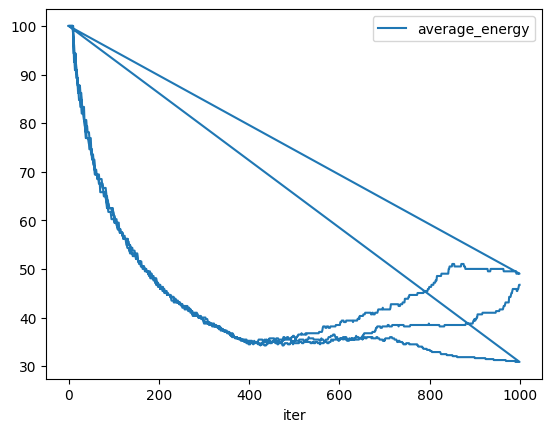

In [49]:
df_agents.plot(x="iter", y="average_energy")

<Axes: xlabel='iter'>

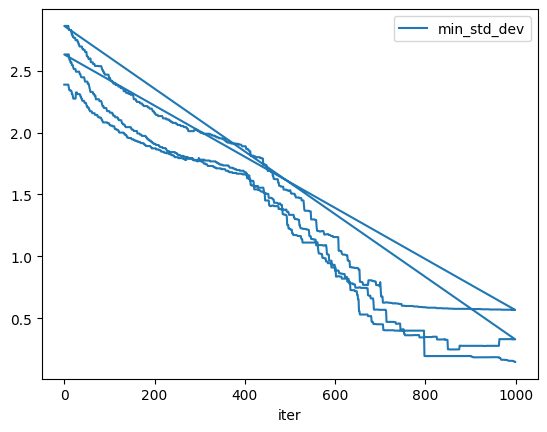

In [50]:
df_agents.plot(x="iter", y="min_std_dev")

<Axes: xlabel='iter'>

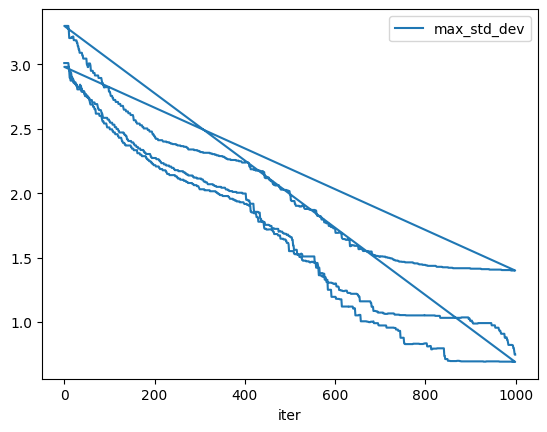

In [51]:
df_agents.plot(x="iter", y="max_std_dev")

In [52]:
df_agents_energy = pd.DataFrame(pandas_data_agents_energy) 
display(df_agents_energy)

,0,1,2,3,4,5,6,7,8,9,...,566,567,568,569,570,571,572,573,574,575
0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,90.250000,90.250000,90.250000,90.250000,90.250000,90.250000,90.250000,90.250000,90.250000,90.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,85.737500,94.762500,85.737500,85.737500,85.737500,85.737500,85.737500,85.737500,85.737500,85.737500,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,81.450625,90.024375,81.450625,81.450625,81.450625,81.450625,90.024375,81.450625,81.450625,81.450625,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.038729,0.007277,100.422645,0.005148,137.946175,75.217323,0.006581,108.032970,0.040542,0.000463
996,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.036792,0.007390,100.436037,0.005148,137.946175,75.217624,0.006252,102.631322,0.038515,0.000440
997,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.034953,0.007020,100.436396,0.005170,137.949595,75.217904,0.006622,102.631473,0.040933,0.000418
998,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.033205,0.006669,100.436396,0.004912,142.801836,80.067252,0.006291,106.987272,0.040987,0.000397


<Axes: xlabel='iter'>

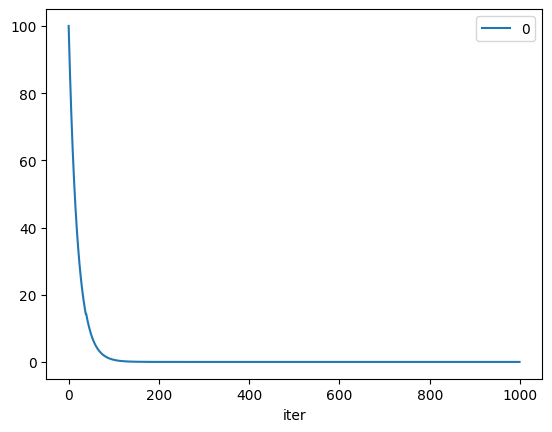

In [53]:
df_agents_energy.plot(x='iter', y="0")

<Axes: xlabel='iter'>

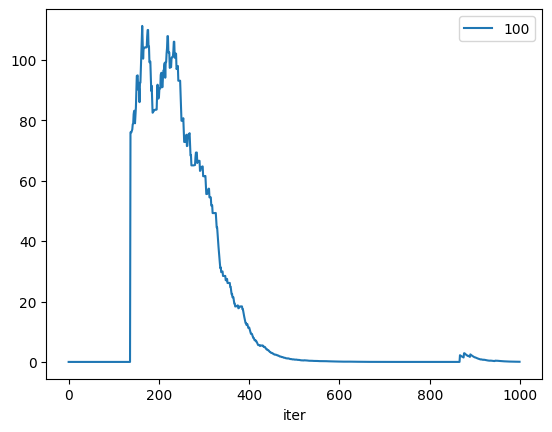

In [54]:
df_agents_energy.plot(x='iter', y="100")

<Axes: xlabel='iter'>

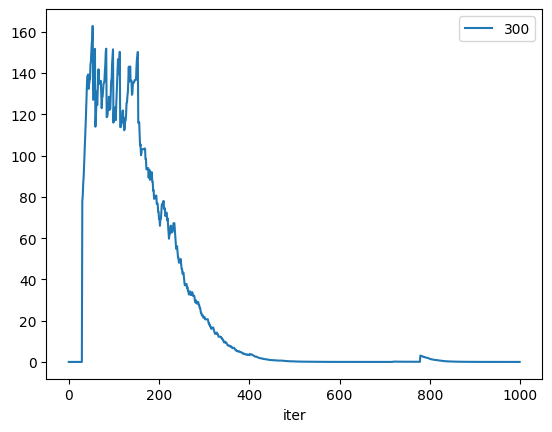

In [55]:
df_agents_energy.plot(x='iter', y="300")

<Axes: xlabel='iter'>

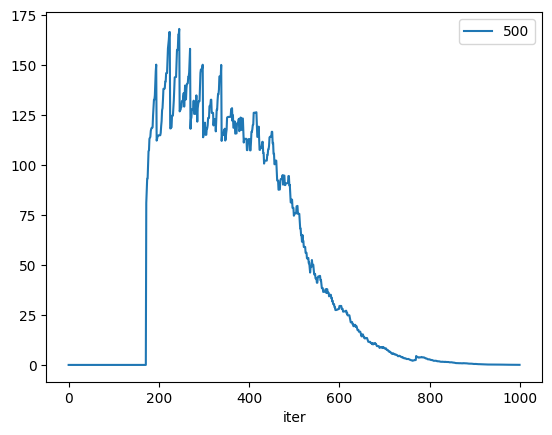

In [56]:
df_agents_energy.plot(x='iter', y="500")

In [57]:
df_agents_energy.plot(x='iter', y="700")

KeyError: '700'

In [58]:
df_agents_energy.plot(x='iter', y="900")

KeyError: '900'